In [1]:
GPT_2_config_124M = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.1,
    "qkv_bias" : False
}

# context_length(num_tokens) means how many tokens are processed at once in an input


In [2]:
# Draw the images of lecture in the copy
# DUMMY GPT Model Class : 
# Example Input : "Every effort moves you"

# Step 1 Tokenization : 
"""
Create tokenIDs from Input text
From the lookup matrix, find out the vector embedding for the tokens

lookup Matrix : vocav_size X emb_dim
pos_matrix : context_length X emb_dim

Our input has 4 tokens
so the output logit matrix will also have 4 tokens
those 4 logits will contain output for the following inputs : 
INPUTS : every , every effort, every effort moves, every effort moves you
OUTPUTS : effort, moves, you,forward

OUTPUT Logits format : [4 X 50257 (vocab_size)]
"""

'\nCreate tokenIDs from Input text\nFrom the lookup matrix, find out the vector embedding for the tokens\n\nlookup Matrix : vocav_size X emb_dim\npos_matrix : context_length X emb_dim\n\nOur input has 4 tokens\nso the output logit matrix will also have 4 tokens\nthose 4 logits will contain output for the following inputs : \nINPUTS : every , every effort, every effort moves, every effort moves you\nOUTPUTS : effort, moves, you,forward\n\nOUTPUT Logits format : [4 X 50257 (vocab_size)]\n'

In [3]:
import torch
from torch import nn

class DummyGPTModel(nn.Module) : 
    def __init__(self,cfg) : 
        # cfg is the config
        super().__init__()
        #token_emb : [vocab_size X emb_size]
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        
        # each input will have max tokens of context_length
        # so we need position embedding of those tokens only
        # pos_emb == [context_length X emb_size]
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
        
    def forward(self, in_idx) :
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

  
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [4]:
import tiktoken
import torch

tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

# batch is a list of inputs tensors
print(batch)

batch = torch.stack(batch,dim = 0)

batch

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_2_config_124M)
logits = model(batch)
print(logits.shape)

torch.Size([2, 4, 50257])


## LAYER NORMALIZATION

In [6]:
from torch import nn

torch.manual_seed(123)
batch_ex = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_ex)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [8]:
mean = out.mean(dim = -1, keepdim = True)
var = out.var(dim = -1, keepdim = True)
mean,var

(tensor([[0.1324],
         [0.2170]], grad_fn=<MeanBackward1>),
 tensor([[0.0231],
         [0.0398]], grad_fn=<VarBackward0>))

In [9]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim = -1, keepdim = True)
var = out_norm.var(dim = -1, keepdim = True)
print(mean,var)

tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
torch.set_printoptions(sci_mode = False)
print(mean)
print(var)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
class LayerNorm(nn.Module) : 
    def __init__(self,emb_dim) : 
        # emb_dim is the embedding dimension of vectos (768)
        super().__init__()
        # eps is a small paramter , its just a very small number
        self.eps = 1e-5
        
        # Scale and shift are two trainable paramters
        # of the same size that of input
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x) : 
#         print(x)
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True, unbiased=False)
        # If keepdim is True, the output tensor is of the same size as input except in the dimension(s) dim where it is of size 1. Otherwise, dim is squeezed (see torch.squeeze()), resulting in the output tensor having 1 (or len(dim)) fewer dimension(s).
        norm_x = (x - mean) / torch.sqrt(var + self.eps) # so that denominator doesnt become 0
#         print(norm_x)
#         print("mul : ", self.scale * norm_x)
#         print("after add is ", self.scale * norm_x + self.shift)
        return self.scale * norm_x + self.shift

        # the scale * norm_x is just element wise multiplication 
        # i.e each element of scale will be multiplied to each element of
        # norm_x, same for shift (addition here)

In [12]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_ex)

mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, unbiased = False, keepdim = True)

print(mean,var)

tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>) tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#GELU activition function

In [13]:
import torch
from torch import nn
class GELU(nn.Module) : 
    def __init__(self) : 
        super().__init__()
        
    def forward(self,x) : 
        return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
        (x + 0.044715 * torch.pow(x,3))
        ))

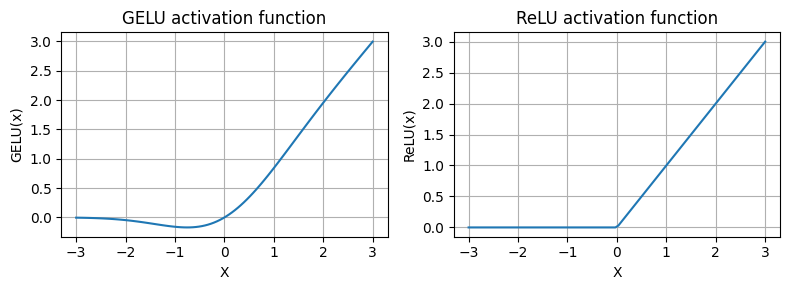

In [14]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

# some sample data : 
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)

# print(y_gelu)
# print(y_relu)

plt.figure(figsize = (8,3))
for i, (y,label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1) :
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("X")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    
plt.tight_layout()
plt.show()

# Dead neuron problem is solved in GELU.

In [20]:
# Feed Forward neural network
# Input : [batch_size, num_tokens, emb_dim]
# Linear --> GELU --> Linear

class FeedForward(nn.Module) : 
    def __init__(self, cfg) : 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), # Expansion
            GELU(), # Activation
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]) # Contraction
        )
                          
    def forward(self, x) :
        # input : [batch_size, tokens, emb_dim]
#         print(x.shape)
        return self.layers(x)
    
        # 1st layer : [batch_size, tokens, 4*emb_dim]
        # GELU : (preserves dim) : [b, num_tokens,4*emb_dim]
        # 2nd layer : [batch_size, tokens, emb_dim]
                

In [24]:
# print(batch.dtype)
feed = FeedForward(GPT_2_config_124M)
feed(torch.randn(2,3,768)).shape

torch.Size([2, 3, 768])


torch.Size([2, 3, 768])

The FeedForward module we implemented in this section plays a crucial role in enhancing the model's ability to learn from and generalize the data.

# SHORTCUT Connections

In [34]:
import torch 
from torch import nn

class DeepNeuralNetwork(nn.Module) : 
    def __init__(self,layer_sizes, use_shortcut) : 
        super().__init__()
        self.use_shortcut =  use_shortcut
        self.layers = nn.ModuleList(
            [
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
            ]
        )
        
    def forward(self, x) :
        for layer in self.layers : 
            # compute the output :
            layer_output = layer(x)
            
            # check for shortcut : 
            
            if self.use_shortcut and x.shape == layer_output.shape : 
                x = x + layer_output
            else : 
                x = layer_output
        return x

In [35]:
layer_sizes = [3,3,3,3,3,1]

sample_input = torch.tensor([1., 0., -1.])
torch.manual_seed(123)
model_without_shortcut = DeepNeuralNetwork(
layer_sizes, use_shortcut= False)
model_with_shortcuts = DeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

# model_without_shortcut(sample_input)

tensor([0.0610], grad_fn=<MulBackward0>)

In [52]:
def print_gradients(model,x) : 
    # Forward Pass : 
    output = model(x)
    target = torch.tensor([0.])
    
    # Loss 
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backpropogation to calculate gradient of each weight
    
    loss.backward()
    
    for name,param in model.named_parameters() : 
        # model.named_paramters outputs weights and bias layer by layer
        if 'weight' in name : 
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            
    

In [53]:
print_gradients(model_without_shortcut, sample_input)


layers.0.0.weight has gradient mean of 0.0016138870269060135
layers.1.0.weight has gradient mean of 0.0009608927648514509
layers.2.0.weight has gradient mean of 0.005721632856875658
layers.3.0.weight has gradient mean of 0.0111909881234169
layers.4.0.weight has gradient mean of 0.04039716720581055


In [54]:
torch.manual_seed(123)
model_with_shortcut = DeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263
